# An Analysis of Key U.S. Economic Indicators (1960s-2020s)

### **Project Goal**
This notebook explores several key U.S. economic indicators sourced from the FRED (Federal Reserve Economic Data) repository. The primary objective is to analyze long-term trends, investigate the correlations between inflation, wages, and unemployment, and test the validity of classic economic theories like the Phillips Curve across different decades.

**Indicators Analyzed:**
- `CPIAUCSL`: Consumer Price Index (Inflation)
- `PCEPI`: Personal Consumption Expenditures Price Index (Inflation)
- `AHETPI`: Average Hourly Earnings of Production and Nonsupervisory Employees (Wages)
- `UNRATE`: Civilian Unemployment Rate
- `DFF`: Federal Funds Effective Rate
    

    
## 1. Setup and Data Loading
First, we'll load the necessary Python libraries for data manipulation and visualization. We then import the pre-processed time-series data from a local CSV file, ensuring the `observation_date` column is correctly parsed as a datetime object.

  

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import YearLocator, DateFormatter

df_all = pd.read_csv('../data/processed/dal.csv')
df_all['observation_date'] = pd.to_datetime(df_all['observation_date'])


## 2. High-Level Correlation Analysis

A correlation heatmap provides a quick, high-level overview of the linear relationships between the different economic indicators in the dataset.

#### **Interpretation:**
As expected, the two primary inflation indicators, **CPI and PCE, are almost perfectly correlated (0.99)**, confirming they measure similar underlying phenomena. A notable **negative correlation exists between the Federal Funds Rate (DFF) and the inflation indicators**, which aligns with the monetary policy principle that raising interest rates is a tool used to curb inflation.


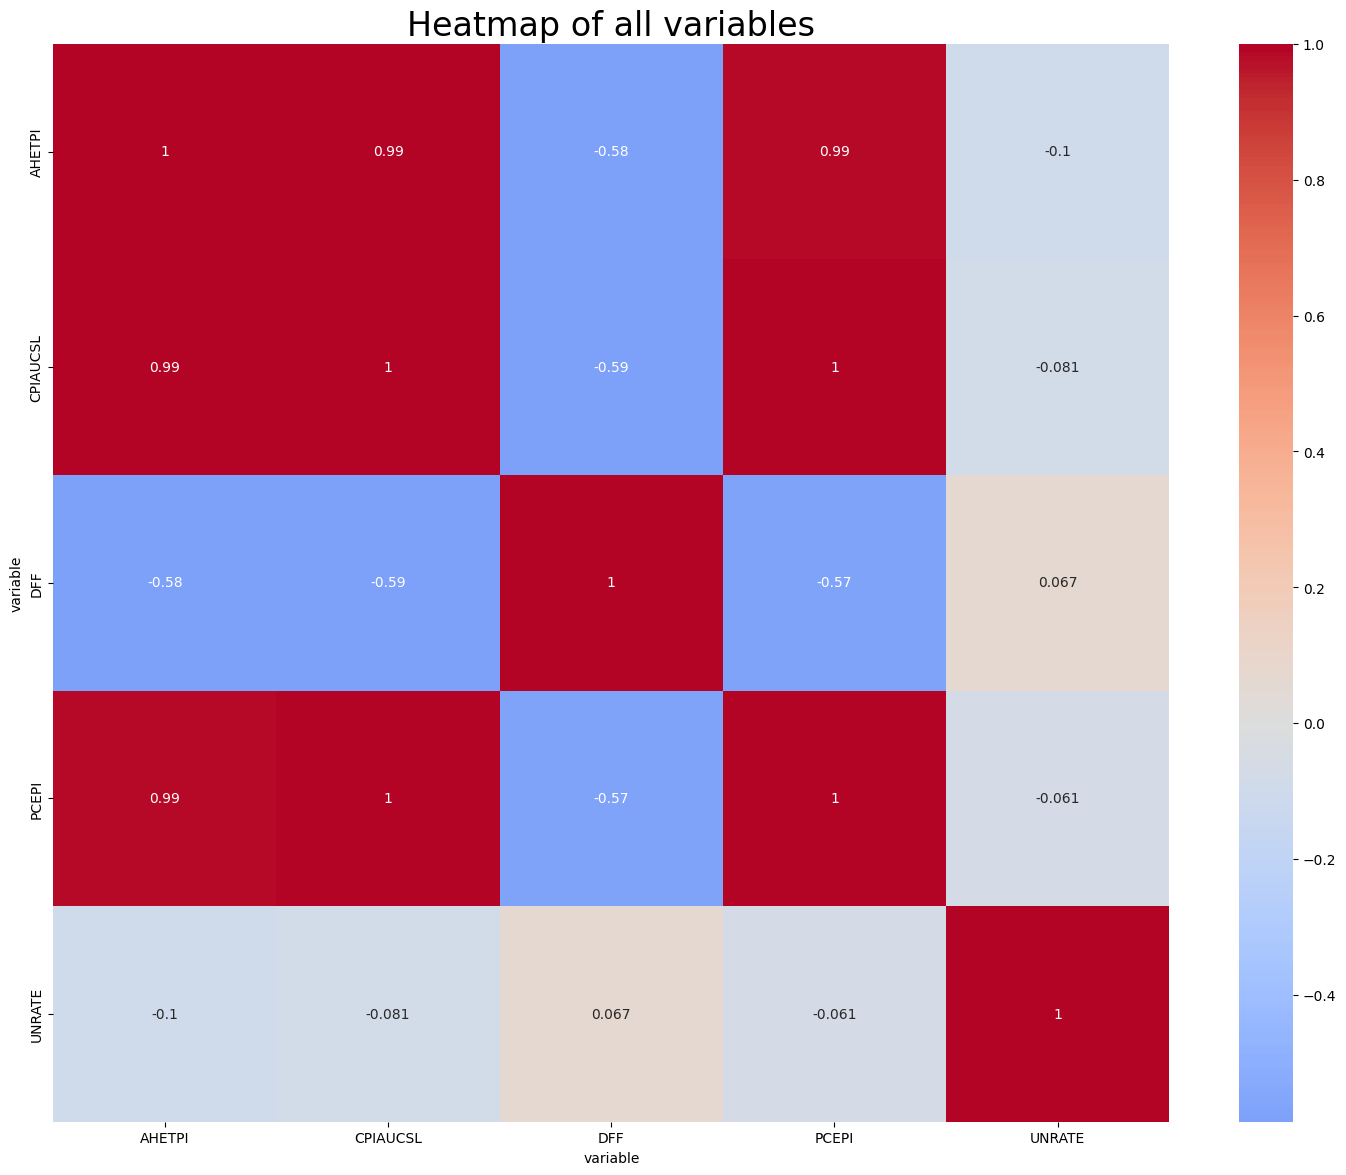

In [2]:
plt.figure(figsize=(18,14))
df_wide = df_all.pivot(index='observation_date', columns='variable', values='value')
corr = df_wide.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Heatmap of all variables', fontsize=24)
plt.show()


## 3. A Closer Look: CPI vs. PCE Inflation

While highly correlated, the Consumer Price Index (CPI) and the Personal Consumption Expenditures (PCE) price index are not identical. This plot visualizes their trends over time to identify periods of convergence and divergence.

#### **Interpretation:**
The visualization confirms that for most of the observed period, the two inflation metrics tracked each other closely. However, a significant **divergence appears in the wake of the 2020 pandemic**, where CPI reported a sharper increase than PCE. This highlights that the choice of inflation metric can have a meaningful impact on economic analysis, especially during periods of high volatility.

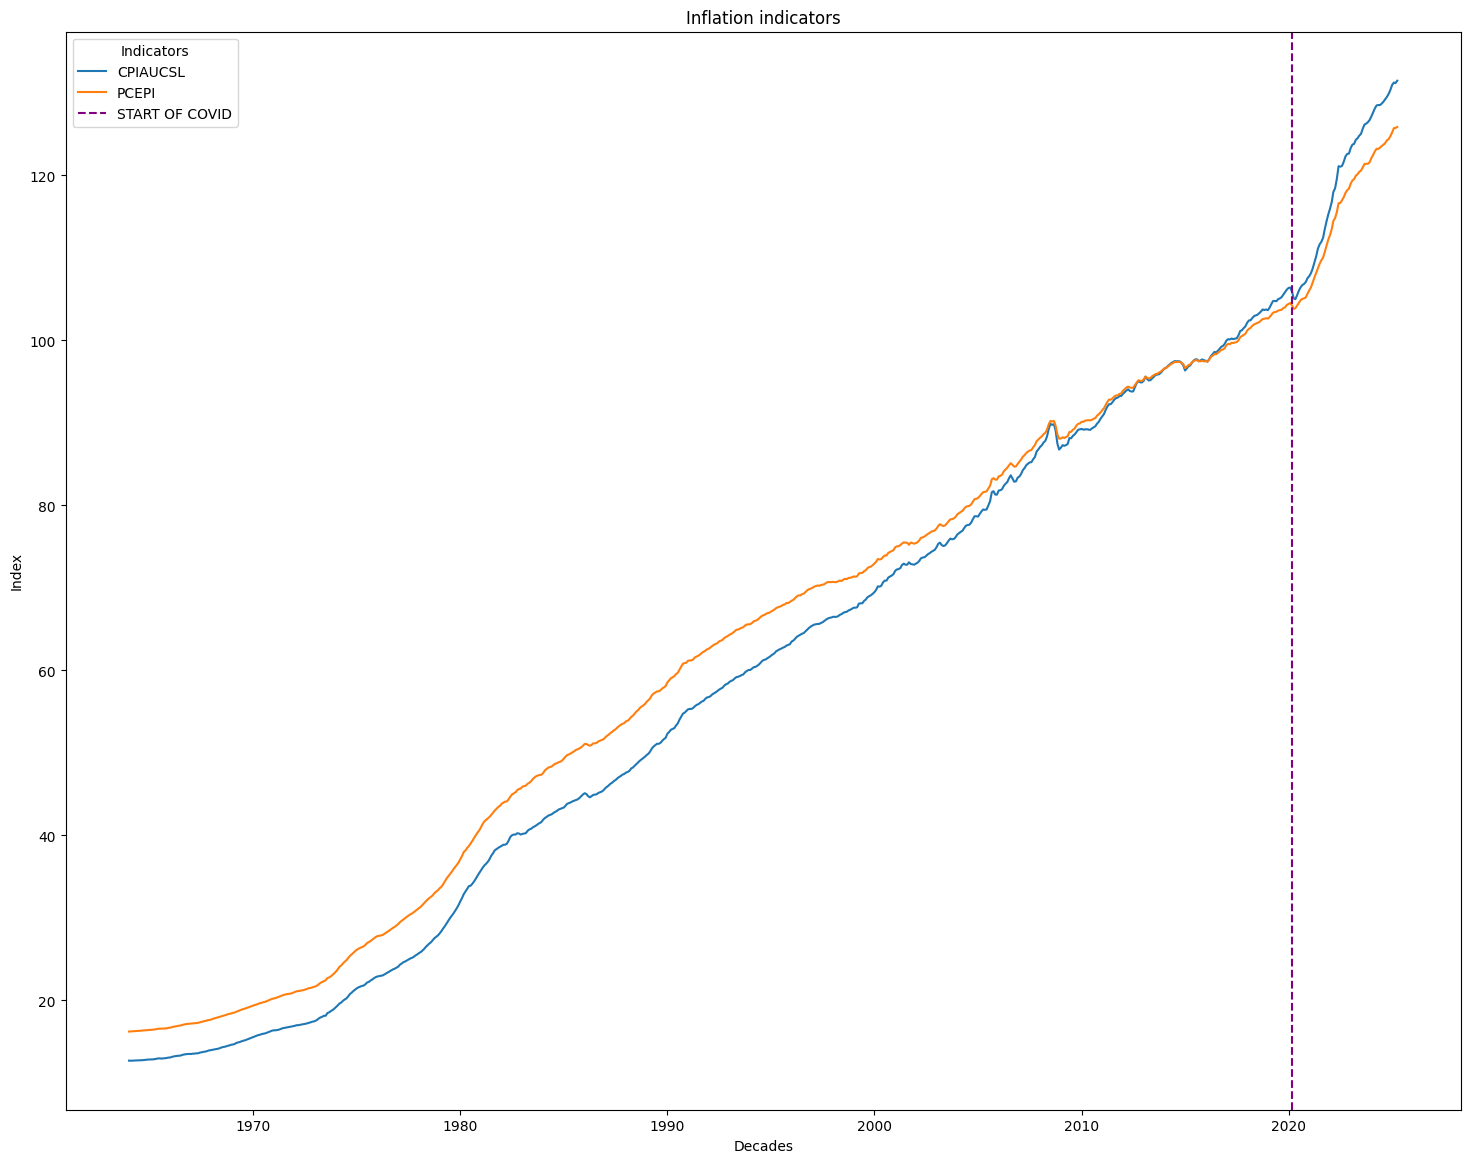

In [3]:
cpiaucsl_df = df_all[df_all['variable'] == 'CPIAUCSL']
pcepi_df = df_all[df_all['variable'] == 'PCEPI']

plt.figure(figsize=(18,14))
sns.lineplot(data=cpiaucsl_df, x='observation_date', y='value', label='CPIAUCSL')
sns.lineplot(data=pcepi_df, x='observation_date', y='value', label='PCEPI')
plt.axvline(x=pd.to_datetime('2020-03-01'),ls='--',color = 'purple',label='START OF COVID')
plt.title('Inflation indicators')
plt.xlabel('Decades')
plt.ylabel('Index')
plt.legend(title='Indicators')
plt.show()


## 4. Normalized Wage Growth vs. Inflation

To compare the growth of wages against inflation on a common scale, we normalize the `AHETPI`, `PCEPI`, and `CPIAUCSL` indicators to a baseline value of 100 as of January 2017. This allows us to track their relative growth since that point in time.

#### **Interpretation:**
The plot clearly illustrates the impact of major economic events. We can observe significant fluctuations in the relationship between wages and inflation during the **2008 financial crisis** and, more dramatically, following the **start of the 2020 pandemic**. All three indicators show a sharp upward trajectory post-2020.


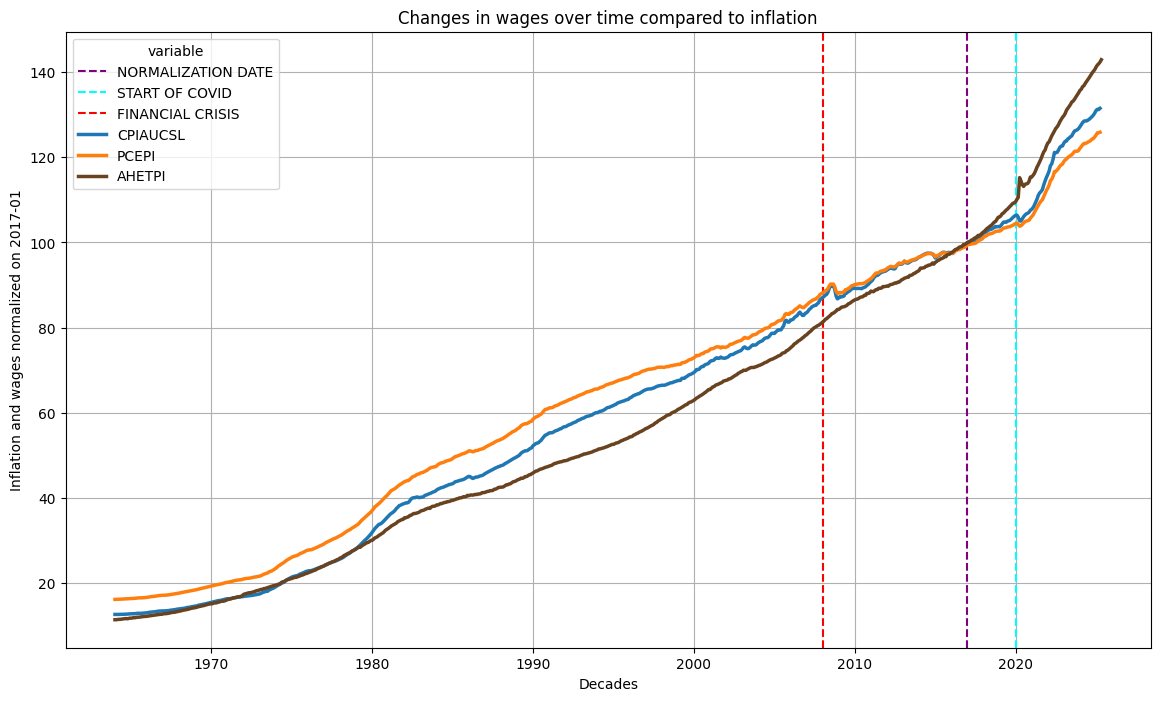

In [4]:
inflation_df = df_all[df_all['variable'].isin(['PCEPI','CPIAUCSL'])]
wages_df = df_all[df_all['variable'] == 'AHETPI'].copy()
base_year = '2017-01-01'
base_value = wages_df[wages_df['observation_date'] == base_year]
wages_df['value'] = (wages_df['value'] / base_value.loc[base_value.index[0], 'value']) * 100

fig, ax1 = plt.subplots(figsize=(14,8))
plt.axvline(x=pd.to_datetime('2017-01-01'),ls='--',color='purple',label='NORMALIZATION DATE')
plt.axvline(x=pd.to_datetime('2020-01-01'),ls='--',color='cyan',label='START OF COVID')
plt.axvline(x=pd.to_datetime('2008-01-01'),ls='--',color='red',label='FINANCIAL CRISIS')
sns.lineplot(data=inflation_df, x='observation_date', y='value', hue='variable', lw=2.5, ax=ax1)
sns.lineplot(data=wages_df, x='observation_date', y='value', hue='variable', palette={'AHETPI':'#69421F'}, lw=2.5, ax=ax1)
plt.title('Changes in wages over time compared to inflation')
plt.xlabel('Decades')
plt.ylabel('Inflation and wages normalized on 2017-01')
plt.grid()
plt.show()


## 5. Has Wage Growth Kept Up with Inflation? A Decadal View

This analysis aims to answer a classic economic question: have wages kept pace with the cost of living? We aggregate the normalized wage and inflation data by decade and plot the difference between the average wage growth and the average inflation rate.

#### **Interpretation:**
The bar chart reveals a striking trend. For every decade from the 1960s to the 2010s, average inflation outpaced the growth of normalized wages, resulting in a negative difference. However, **for the first time in over 60 years, this trend reversed in the 2020s**, where average wage growth has thus far exceeded the average inflation rate.


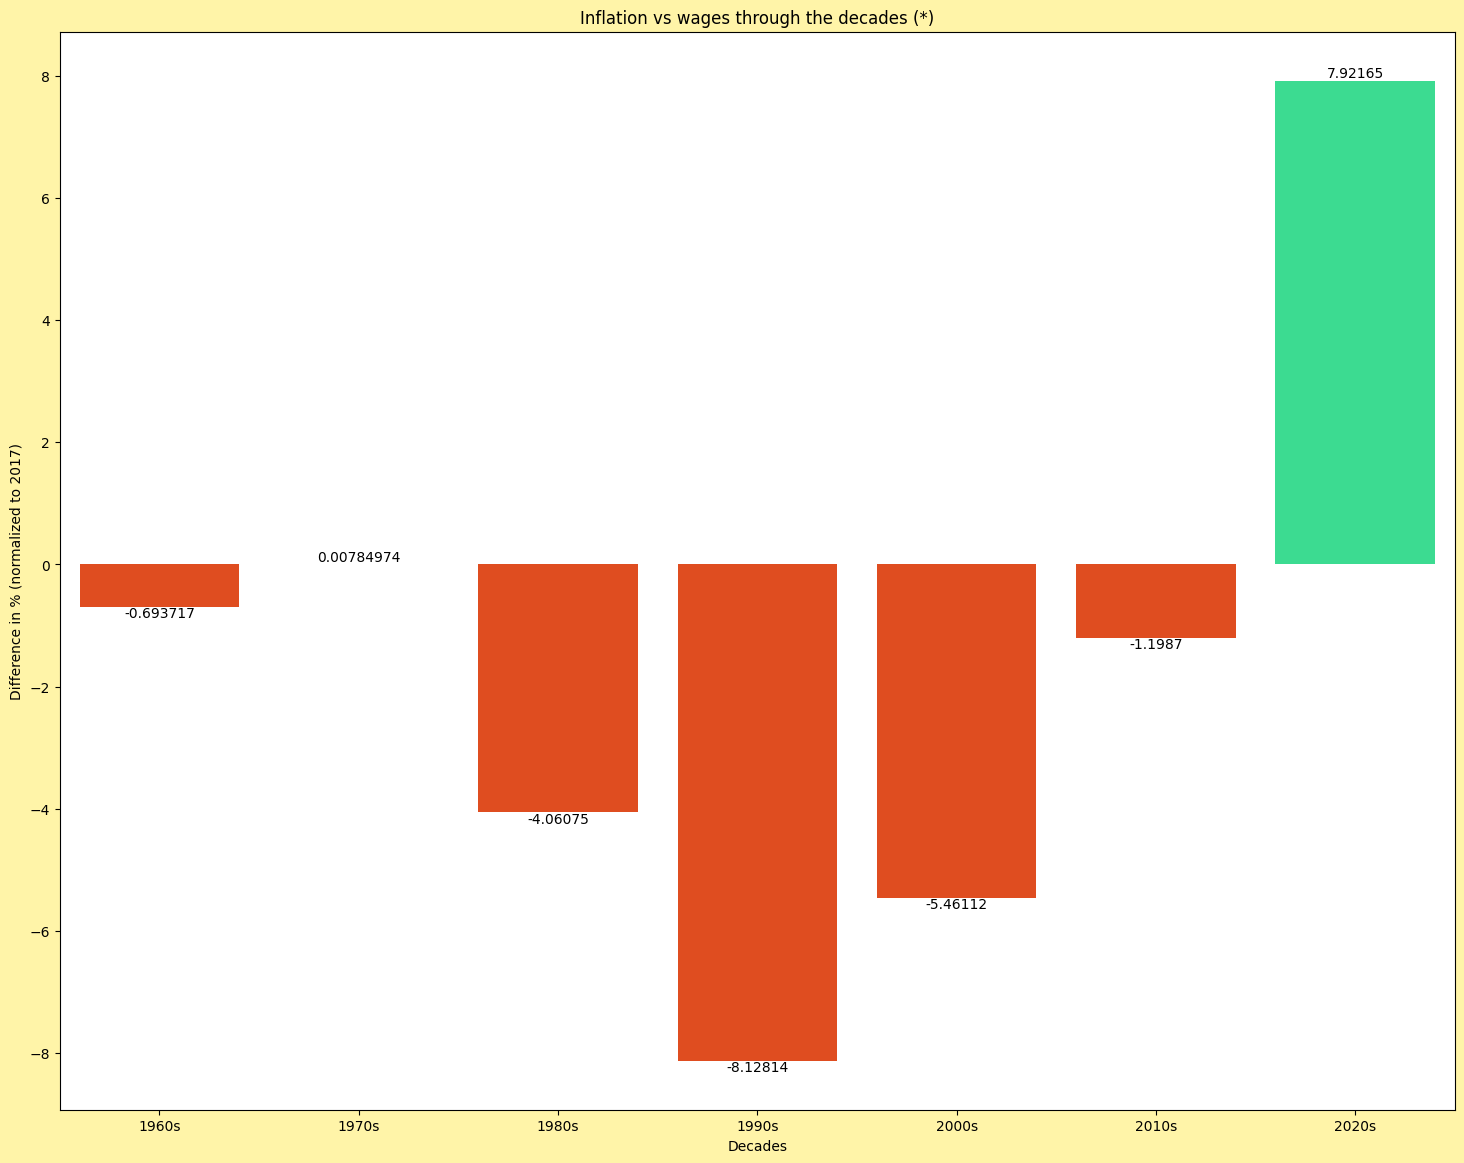

In [5]:
inflation_wages_df = df_all[df_all['variable'].isin(['CPIAUCSL', 'AHETPI'])].copy()
inflation_wages_df['decades'] = (inflation_wages_df['observation_date'].dt.year //10) * 10
inflation_wages_df['decades'] = inflation_wages_df['decades'].map({
    1960:'1960s', 1970:'1970s', 1980:'1980s', 1990:'1990s', 2000:'2000s',
    2010:'2010s', 2020:'2020s'
})
inflation_df = inflation_wages_df[inflation_wages_df['variable']=='CPIAUCSL'].copy()
aggregated_inflation = inflation_df.groupby('decades')['value'].mean().reset_index()
wages_df = inflation_wages_df[inflation_wages_df['variable']=='AHETPI'].copy()
wages_df['value'] = (wages_df['value'] / base_value.loc[base_value.index[0], 'value']) * 100
aggregated_wages = wages_df.groupby('decades')['value'].mean().reset_index()
merged = pd.merge(aggregated_wages, aggregated_inflation, on='decades', suffixes=('_wages','_inflation'))
merged['difference'] = merged['value_wages'] - merged['value_inflation']

colors = {row['decades']: ('#FF3C00' if row['difference'] < 0 else '#21F693') for _,row in merged.iterrows()}

plt.figure(figsize=(18,14), facecolor='#FFF4A8')
ax = sns.barplot(data=merged, x='decades', y='difference',hue='decades', palette=colors)
plt.title('Inflation vs wages through the decades (*)')
plt.ylabel('Difference in % (normalized to 2017)')
plt.xlabel('Decades')
for container in ax.containers:
    ax.bar_label(container)
plt.show()


## 6. Average Unemployment Rate by Decade

This chart provides a historical overview of the U.S. unemployment rate, aggregated by decade to smooth out short-term business cycles. The decades with the highest and lowest average unemployment are highlighted for emphasis.

#### **Interpretation:**
The visualization identifies the **1980s as the decade with the highest average unemployment**, largely influenced by the recession in the early part of the decade. Conversely, the **1960s experienced the lowest average unemployment rate** of the periods analyzed.

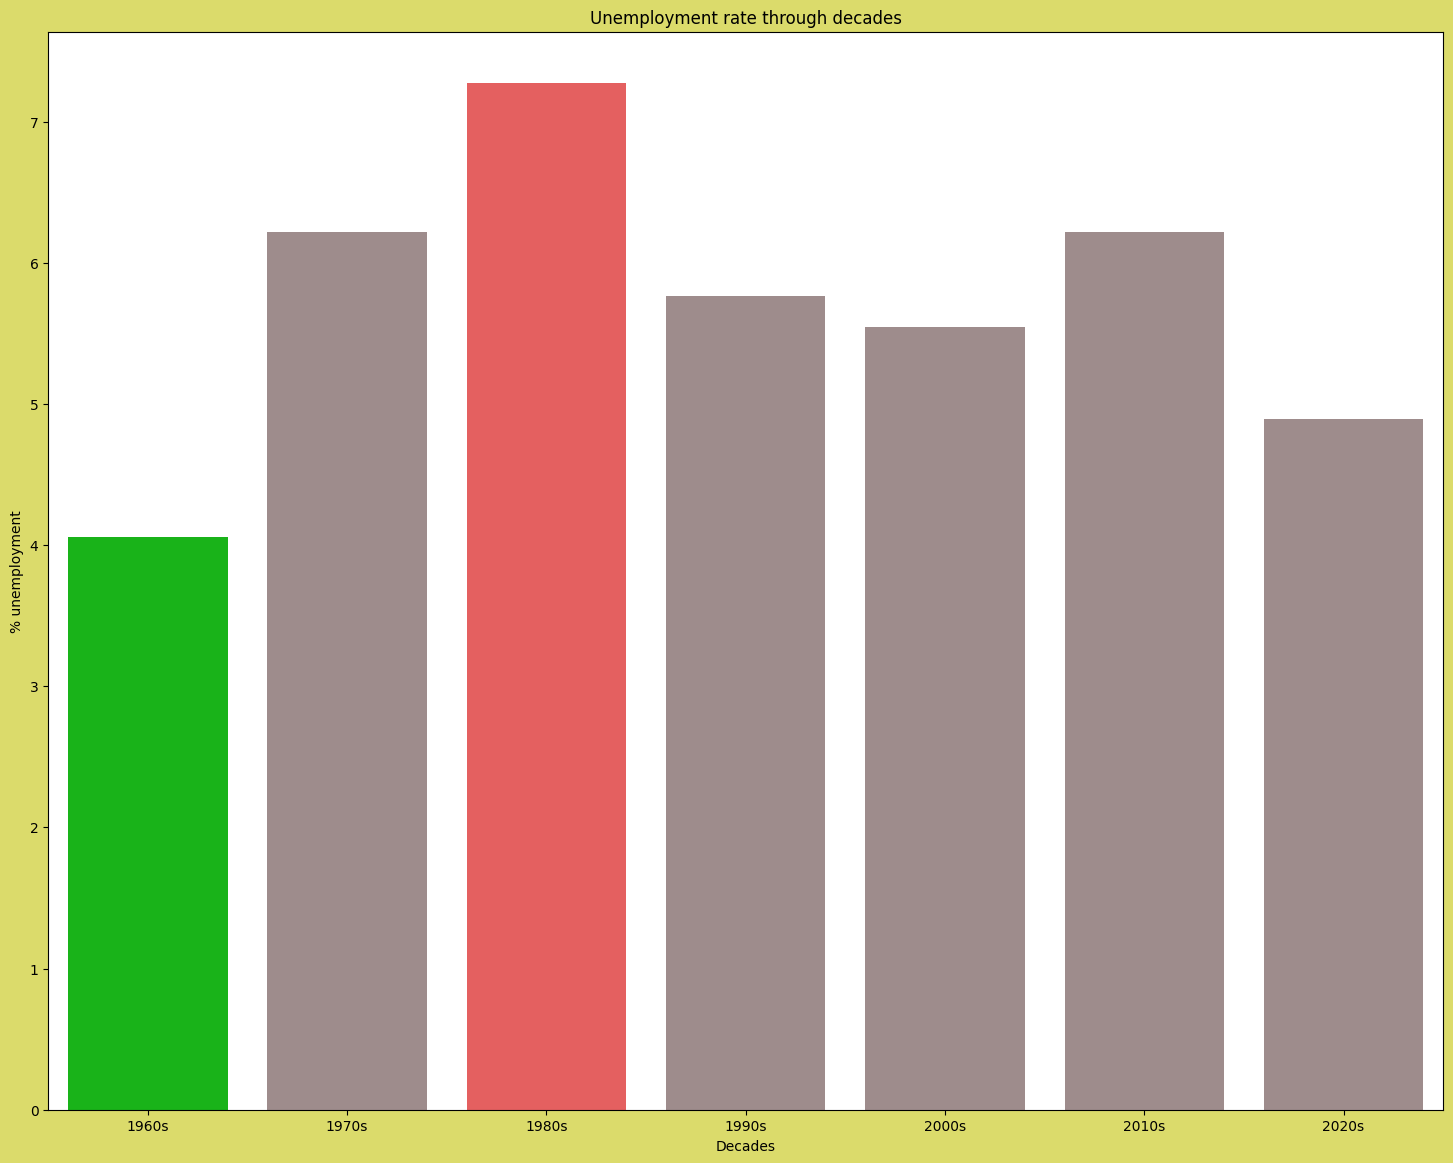

In [6]:
unrate_df = df_all[df_all['variable']=='UNRATE'].copy()
unrate_df['decades'] = (unrate_df['observation_date'].dt.year // 10) * 10
unrate_df['decades'] = unrate_df['decades'].map({
    1960:'1960s', 1970:'1970s', 1980:'1980s', 1990:'1990s', 2000:'2000s',
    2010:'2010s', 2020:'2020s'
})
agg = unrate_df.groupby('decades')['value'].mean().reset_index()
max_decade = agg.loc[agg['value'].idxmax(),'decades']
min_decade = agg.loc[agg['value'].idxmin(),'decades']
colors = {d:('#fa4a4a' if d==max_decade else '#00cc00' if d==min_decade else '#a18989') for d in agg['decades']}

plt.figure(figsize=(18,14), facecolor='#DBDB6B')
sns.barplot(data=agg, x='decades', y='value',hue='decades', palette=colors)
plt.title('Unemployment rate through decades')
plt.ylabel('% unemployment')
plt.xlabel('Decades')
plt.show()


## 7. Phillips Curve Analysis by Decade

The Phillips Curve is an economic theory postulating an inverse relationship between unemployment and inflation. To test this theory, we plot the unemployment rate (x-axis) against the year-over-year inflation rate (y-axis) and use a LOWESS smoother to visualize the trend for each decade.

#### **Interpretation:**
The analysis shows that the Phillips Curve is not a stable, universal law. A clear inverse relationship, as predicted by the theory, is visible in the **1960s**. The relationship is less clear but arguably present in the **2000s** and **2020s**. However, other decades, like the 1970s (a period of "stagflation"), show a positive or flat relationship. This suggests that the inverse correlation between unemployment and inflation is not a given, but rather depends on a specific set of broader economic conditions.

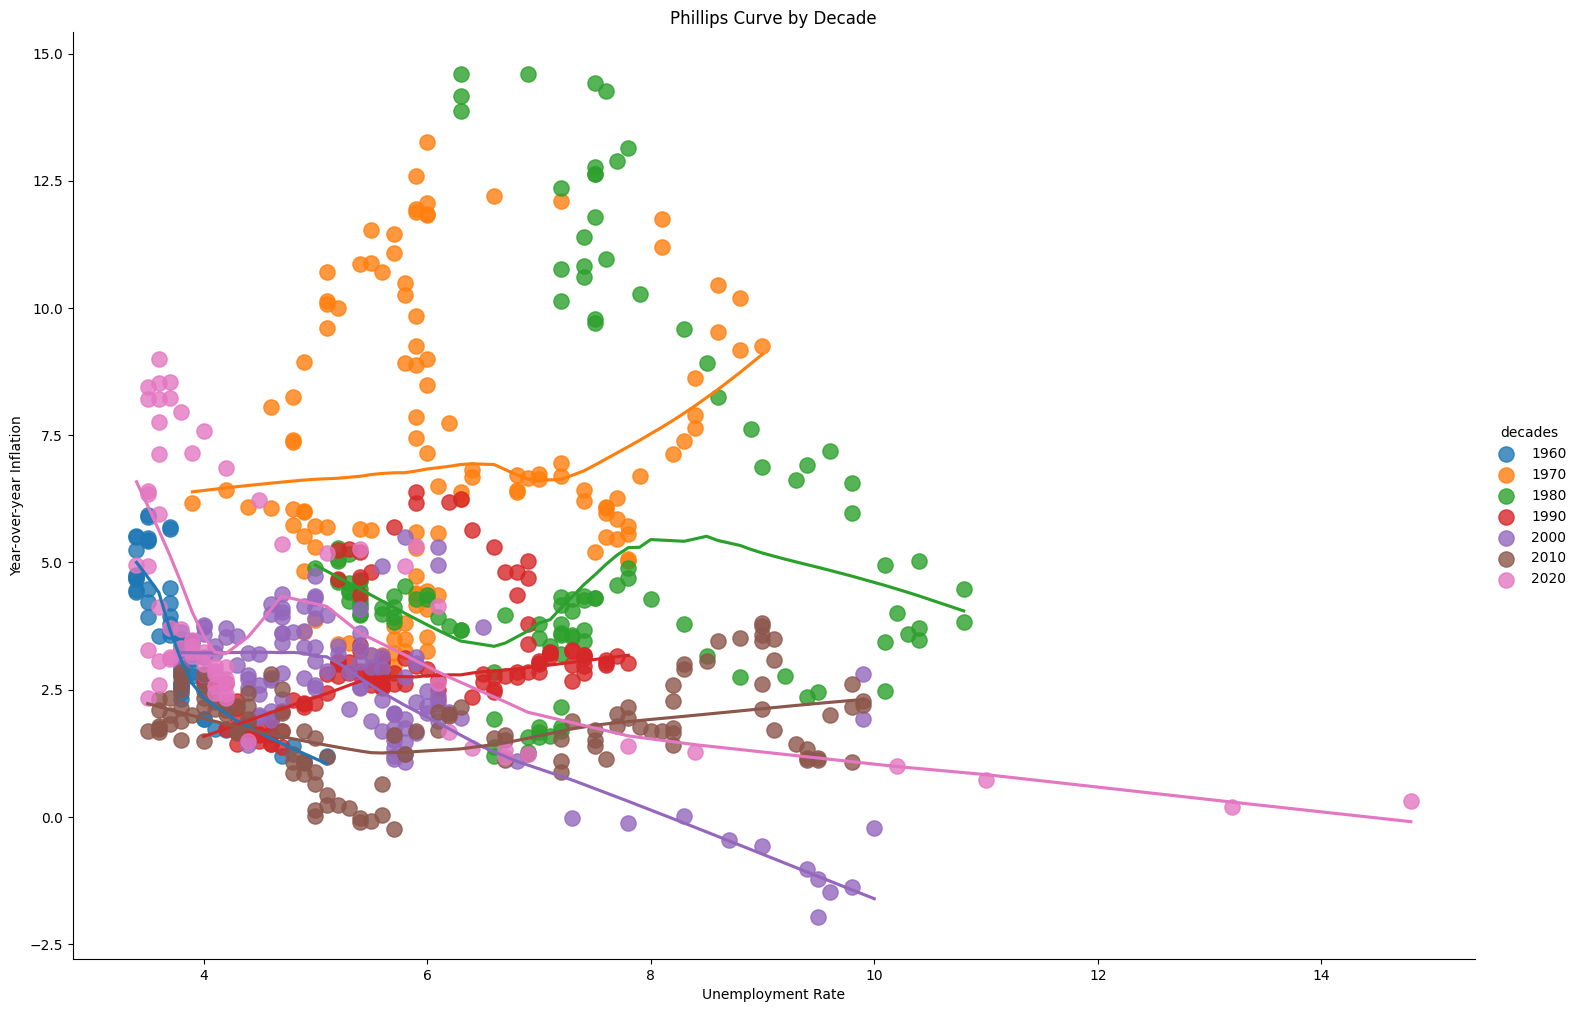

In [7]:
unrate_df = df_all[df_all['variable']=='UNRATE']
inflation_df = df_all[df_all['variable']=='CPIAUCSL']
base_value = 243.618

merged = pd.merge(unrate_df,inflation_df,on='observation_date',suffixes=('_unrate','_inflation'))
merged['unnormalized'] = (merged['value_inflation']/100)*base_value
merged['YoY_inflation'] = merged['unnormalized'].pct_change(periods=12)*100
merged['decades'] = (merged['observation_date'].dt.year//10)*10
merged = merged.dropna(subset=['YoY_inflation'])

sns.lmplot(data=merged, x='value_unrate', y='YoY_inflation', hue='decades', lowess=True,
           height=10, aspect=1.5, scatter_kws={'s':120})
plt.title('Phillips Curve by Decade')
plt.xlabel('Unemployment Rate')
plt.ylabel('Year-over-year Inflation')
plt.show()
